# Image analysis with fMRI 3D images imported with Loris API

In [ ]:
# Uncomment and run to install the packages required to run the notebook
# !pip3 install tqdm
# !pip3 install numpy
# !pip3 install nibabel
# !pip3 install sklearn
# !pip3 install itertools
# !pip3 install matplotlib
# !pip3 install nilearn

In [1]:
import getpass        # For input prompt not to show what is entered
import json           # Provide convinent functions to handle json objects 
import re             # For regular expression
import requests       # To handle http requests
import nibabel as nib
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import os
warnings.simplefilter('ignore') # Because I am using unverified ssl certificates 

baseurl = 'https://test-loris-dev.loris.ca/api/v0.0.3' # Pick yours

def prettyPrint(string):
    print(json.dumps(string, indent=2, sort_keys=True))

## Login

In [2]:
payload = {
    'username': input('username: '), 
    'password': getpass.getpass('password: ')
}

response = requests.post(
    url = baseurl + '/login',
    json = payload,
    verify = False
)

text = response.content.decode('ascii')
data = json.loads(text)
token = data['token']

username: admin
password: ········


## Getting the data

In [3]:
basedir = 'fmri'
if basedir not in os.listdir():
    os.mkdir(basedir)
if 't1' not in os.listdir(basedir):
    os.mkdir(basedir + '/t1/')
if 't2' not in os.listdir(basedir):
    os.mkdir(basedir + '/t2/')
if 'raw' not in os.listdir(basedir + '/t1/'):
    os.mkdir(basedir + '/t1/raw/')
if 'raw' not in os.listdir(basedir + '/t2/'):
    os.mkdir(basedir + '/t2/raw/')

#### First, get the information necessary to retrieve all images from all the projects

In [4]:
import os
# Find the project name and site name.
projects = json.loads(requests.get(
    url = baseurl + '/projects',
    verify = False,
    headers = {'Authorization': 'Bearer %s' % token}
).content.decode('ascii'))

projectnames = list(projects['Projects'])

candidates = dict.fromkeys(projectnames)
imagesMeta = dict.fromkeys(projectnames)
t1_list = []
t2_list = []
dwi25_list = []

for project in projectnames:
    imagesMeta[project] = json.loads(requests.get(
        url = baseurl + '/projects/' + project + '/images',
        verify = False,
        headers = {'Authorization': 'Bearer %s' % token}
            ).content.decode('ascii'))

For this tutorial, we will compare T1 and T2 images. This should be a trivial analysis, as these are easy to differentiate even for an untrained person.

The images will first be saved as raw images (no modification of the images)

In [5]:
pbar = tqdm(total=sum([len([meta for meta in imagesMeta[p]['Images'] if meta['ScanType'] in ['t1', 't2']]) for p in projectnames]))
i = 0
t = None
if 'raw' not in os.listdir(basedir + '/t1'):
    os.mkdir(basedir + '/t1/raw')

if 'raw' not in os.listdir(basedir + '/t2'):
    os.mkdir(basedir + 't2/raw')

for project in projectnames:
    for i, meta in enumerate(imagesMeta[project]['Images']):
        if(meta['ScanType'] not in ['t1', 't2']):
            continue
        r = requests.get(baseurl + meta['Link'], 
                     headers = {'Authorization': 'Bearer %s' % token})
        page = r.content
        filename = meta['Link'].split('/')[-1]
        if(meta['ScanType'] == 't1'):
            file_ = open(basedir + '/t1/raw/' + filename, 'wb')
            t = 't1'
        elif(meta['ScanType'] == 't2'):
            file_ = open(basedir + '/t2/raw/' + filename, 'wb')
            t = 't2'
        else:
            continue
        file_.write(page)
        file_.close()
        img = nib.load('/run/media/simon/DATA&STUFF/data/biology/images/' + t +'/raw/' + filename)
        data = img.get_fdata()

        if(meta['ScanType'] == 't1'):
            t1_list += [data]
        if(meta['ScanType'] == 't2'):
            t2_list += [data]
        pbar.update(1)
    # nib.Nifti1Image(data, np.eye(4))

## Preprocessing

In this section, we'll explore a few preprocessing methods that might make the models learned perform better.

### Resize images

It is common practice to reduce large images before training a model in machine learning. Large images have the advantage of containing more information, but it comes with a tradeoff known as the Curse of dimentionality. Having a high dimentionality can makes it much easier to have good performances on the training set, but the models trained overfit more easily to the training data and perform poorly on the validation and test data.

Of course, reducing images too much will also harm the performance of the model trained. There is no rule of thumb or algorithm to get the optimal size of images to be used in a specific task, so it might be a good idea to try a few different reductions.

This tutorial will explore 2 dimensions. Both will cubes (all sides have the same length): 128x128x128 and 32x32x32. The later dimensions might be a huge reduction, but the 3D images still have 32,768 dimensions (each voxel being a dimension), which is still huge, but much more manageable than the larger reduction, which has 2,097,152 dimensions. In order to decide which reduction to use, we will observe the data using a Principal Component Analysis (PCA). It will give an idea of wheter the data has lost too much information to use it in a classification task. 

Ultimately, it might be necessary to use both strategies to test if one is better than the other. In case both strategies appear to be equal, Ockham's razor principle suggest the images with fewer voxels should be used. In this case, the notion of equality is somewhat arbitrary and might depend on the task to be accomplished.

In [6]:
import itertools
def resize_data(data, new_size=(160, 160, 160)):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = new_size[0]
    new_size_y = new_size[1]
    new_size_z = new_size[2]

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data


In order to save the data that will be acquired

In [7]:
basedir = 'fmri'
dir1 = "32x32"
dir2 = "128x128"
if basedir not in os.listdir():
    os.mkdir(basedir)
if 't1' not in os.listdir(basedir):
    os.mkdir(basedir + '/t1/')
if 't2' not in os.listdir(basedir):
    os.mkdir(basedir + '/t2/')
if dir1 not in os.listdir(basedir + '/t1/'):
    os.mkdir(basedir + '/t1/' + dir1)
if dir2 not in os.listdir(basedir + '/t1/'):
    os.mkdir(basedir + '/t1/' + dir2)
if dir1 not in os.listdir(basedir + '/t2/'):
    os.mkdir(basedir + '/t2/' + dir1)
if dir2 not in os.listdir(basedir + '/t2/'):
    os.mkdir(basedir + '/t2/' + dir2)


### Visualisation with nilearn

Visualisation of the raw images and the 2 reductions for T1 and T2 images.

#### T1 images

Original (160x256x224)


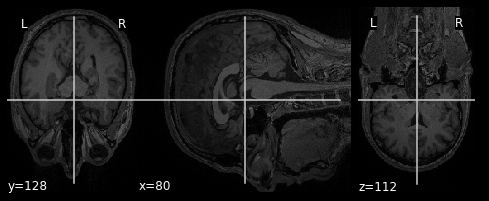

128x128x128


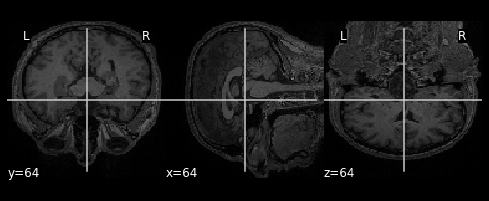

32x32x32


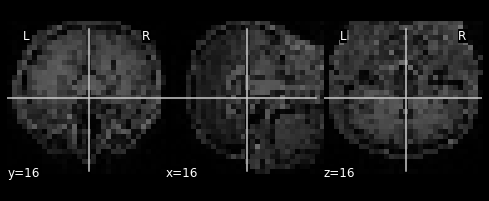

In [8]:
import nilearn.plotting as nlplt
t1_fullimage = nib.Nifti1Image(t1_list[0], np.eye(4))
img_t1_128 = nib.Nifti1Image(resize_data(t1_list[0], (128, 128, 128)), np.eye(4))
img_t1_32 = nib.Nifti1Image(resize_data(t1_list[0], (32, 32, 32)), np.eye(4))
nlplt.plot_anat(t1_fullimage, (80, 128, 112))
print("Original (160x256x224)")
nlplt.show()
nlplt.plot_anat(img_t1_128, (64, 64, 64))
print("128x128x128")
nlplt.show()
nlplt.plot_anat(img_t1_32, (16, 16, 16))
print("32x32x32")
nlplt.show()


#### T2 images

Original (160x256x224)


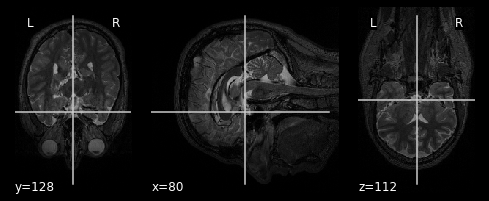

128x128x128


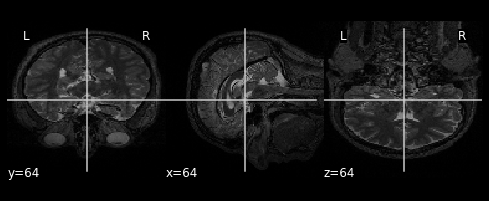

32x32x32


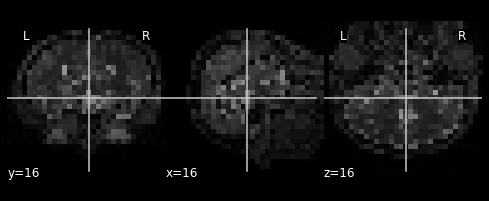

In [9]:
import nilearn.plotting as nlplt
t2_fullimage = nib.Nifti1Image(t2_list[0], np.eye(4))
img_t2_128 = nib.Nifti1Image(resize_data(t2_list[0], (128, 128, 128)), np.eye(4))
img_t2_32 = nib.Nifti1Image(resize_data(t2_list[0], (32, 32, 32)), np.eye(4))
nlplt.plot_anat(t2_fullimage, (80, 128, 112))
print("Original (160x256x224)")
nlplt.show()
nlplt.plot_anat(img_t2_128, (64, 64, 64))
print("128x128x128")
nlplt.show()
nlplt.plot_anat(img_t2_32, (16, 16, 16))
print("32x32x32")
nlplt.show()


#### Resize and normalize all T1 images

In [11]:
pbar = tqdm(total=len(os.listdir(basedir + '/t1/raw/')))
t1_max_voxel = 0
t1_min_voxel = np.inf
t1_max_voxel2 = 0
t1_min_voxel2 = np.inf
t1_list_resize32 = []
t1_list_resize128 = []
for i, fname in enumerate(os.listdir(basedir + '/t1/raw/')):
    x = np.array(nib.load(basedir + '/t1/raw/' + fname).dataobj)
    x1 = resize_data(x, (32, 32, 32))
    x1 = x1 / np.max(x1)
    if np.max(x1) > t1_max_voxel:
        t1_max_voxel = np.max(x1)
    if np.min(x1) < t1_min_voxel:
        t1_min_voxel = np.min(x1)
    x2 = resize_data(x, (128, 128, 128))
    x2 = x2 / np.max(x2)
    if np.max(x2) > t1_max_voxel2:
        t1_max_voxel2 = np.max(x2)
    if np.min(x2) < t1_min_voxel2:
        t1_min_voxel2 = np.min(x2)
    t1_list_resize32 += [x1]
    t1_list_resize128 += [x2]
    
    """
    Reasons why the images are saved to disk:
        1- Saves time: No need to resize the images mutliple in ML algorithm
        2- Saves RAM: Large datasets might be too large to keep in the memory
        3- Datasets are easier to prepare for Deep Learning Frameworks 
           (e.g. pyTorch or Tensorflow)          
    """
    img = nib.Nifti1Image(x1, np.eye(4))
    img.to_filename(basedir + '/t1/' + dir1 + '/' + fname + '.nii')
    img2 = nib.Nifti1Image(x2, np.eye(4))
    img2.to_filename(basedir + '/t1/' + dir2 + '/' + fname + '.nii')
    pbar.update(1)

print("\nmax:", t1_max_voxel)
print('min:', t1_min_voxel)
print("\nmax:", t1_max_voxel2)
print('min:', t1_min_voxel2)


max: 1.0
min: 0.0

max: 1.0
min: 0.0


#### Resize and normalize T2 images

In [12]:
pbar = tqdm(total=len(os.listdir(basedir + '/t2/raw/')))
t2_max_voxel = 0
t2_min_voxel = np.inf
t2_max_voxel2 = 0
t2_min_voxel2 = np.inf
t2_list_resize32 = []
t2_list_resize128 = []
for i, fname in enumerate(os.listdir(basedir + '/t2/raw/')):
    x = np.array(nib.load(basedir + '/t2/raw/' + fname).dataobj)
    x1 = resize_data(x, (32, 32, 32))
    x1 = x1 / np.max(x1)
    if np.max(x1) > t2_max_voxel:
        t2_max_voxel = np.max(x1)
    if np.min(x1) < t2_min_voxel:
        t2_min_voxel = np.min(x1)
    x2 = resize_data(x, (128, 128, 128))
    x2 = x2 / np.max(x2)
    if np.max(x2) > t2_max_voxel2:
        t2_max_voxel2 = np.max(x2)
    if np.min(x2) < t2_min_voxel2:
        t2_min_voxel2 = np.min(x2)
    t2_list_resize32 += [x1]
    t2_list_resize128 += [x2]
    
    """
    Reasons why the images are saved to disk:
        1- Saves time: No need to resize the images mutliple in ML algorithm
        2- Saves RAM: Large datasets might be too large to keep in the memory
        3- Datasets are easier to prepare for Deep Learning Frameworks 
           (e.g. pyTorch or Tensorflow)          
    """
    img = nib.Nifti1Image(x1, np.eye(4))
    img.to_filename(basedir + '/t2/' + dir1 + '/' + fname + '.nii')
    img2 = nib.Nifti1Image(x2, np.eye(4))
    img2.to_filename(basedir + '/t2/' + dir2 + '/' + fname + '.nii')
    pbar.update(1)

print("\nmax:", t2_max_voxel)
print('min:', t2_min_voxel)
print("\nmax:", t2_max_voxel2)
print('min:', t2_min_voxel2)


max: 1.0
min: 0.0

max: 1.0
min: 0.0


## Unsupervised learning: Principal Component Analysis

Prcincipal Component Analysis is a popular method used for dimensioanlity reduction, which is a good first step to vizualise the data to analyse and can give insight for the subsequent steps of the analysis. 

Dimensionality reduction can also be used to transform the data before using it to train a ML model, but we won't use it for that purpose. PCA is a linear model and has a low capacity compared to other non-linear models, especially compared to deep neural networks such as Autoencoders (PCA is basically an autoencoder with no hidden layers and no non-linear activation, with the exception that the linear transformations in an autoencoder are not orthogonal).

In [54]:
# Make numpy arrays from the lists of numpy arrays
t1_resize32 = np.stack(t1_list_resize32)
t2_resize32 = np.stack(t2_list_resize32)
t1_resize128 = np.stack(t1_list_resize128)
t2_resize128 = np.stack(t2_list_resize128)

# sklearn needs the data to be flattened
t1_resize128_flatten = t1_resize128.reshape([t1_resize128.shape[0], -1])
t2_resize128_flatten = t2_resize128.reshape([t2_resize128.shape[0], -1])
t1_resize32_flatten = t1_resize32.reshape([t1_resize32.shape[0], -1])
t2_resize32_flatten = t2_resize32.reshape([t2_resize32.shape[0], -1])
t1_shape = t1_resize128_flatten.shape
t2_shape = t2_resize128_flatten.shape

# We make one dataset with all the T1 and T2 flattened data
t1t2_resize128_flatten = np.concatenate([t1_resize128_flatten[:30], t2_resize128_flatten[:30]])
t1t2_resize128_flatten_valid = np.concatenate([t1_resize128_flatten[30:], t2_resize128_flatten[30:]])
t1t2_resize32_flatten = np.concatenate([t1_resize32_flatten[:30], t2_resize32_flatten[:30]])
t1t2_resize32_flatten_valid = np.concatenate([t1_resize32_flatten[30:], t2_resize32_flatten[30:]])
t1t2_shape = t1t2_resize128_flatten.shape



128x128x128


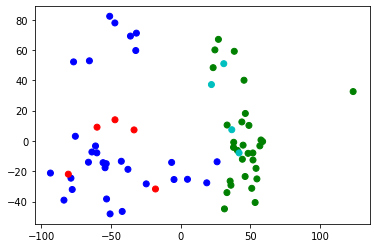

32x32x32


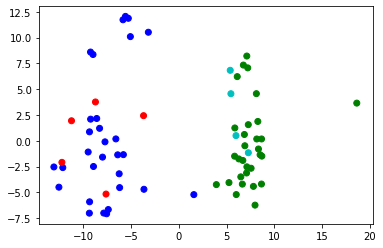

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
print('128x128x128')
pca128 = PCA(n_components=2)
pca128.fit(t1t2_resize128_flatten)
t1_transform = pca128.transform(t1_resize128_flatten[:30])
t2_transform = pca128.transform(t2_resize128_flatten[:30])
t1_transform_valid = pca128.transform(t1_resize128_flatten[30:])
t2_transform_valid = pca128.transform(t2_resize128_flatten[30:])

colors = ['b' for x in range(len(t1_resize128_flatten[:30]))]
plt.scatter(t1_transform[:, 0], t1_transform[:, 1], c=colors)
colors = ['g' for x in range(len(t2_resize128_flatten[:30]))]
plt.scatter(t2_transform[:, 0], t2_transform[:, 1], c=colors)
colors = ['r' for x in range(len(t1_resize128_flatten[30:]))]
plt.scatter(t1_transform_valid[:, 0], t1_transform_valid[:, 1], c=colors)
colors = ['c' for x in range(len(t2_resize128_flatten[30:]))]
plt.scatter(t2_transform_valid[:, 0], t2_transform_valid[:, 1], c=colors)
plt.show()
plt.close()

print('32x32x32')
pca32 = PCA(n_components=2)
pca32.fit(t1t2_resize32_flatten)
t1_transform = pca32.transform(t1_resize32_flatten[:30])
t2_transform = pca32.transform(t2_resize32_flatten[:30])
t1_transform_valid = pca32.transform(t1_resize32_flatten[30:])
t2_transform_valid = pca32.transform(t2_resize32_flatten[30:])

colors = ['b' for x in range(len(t1_resize32_flatten[:30]))]
plt.scatter(t1_transform[:, 0], t1_transform[:, 1], c=colors)
colors = ['g' for x in range(len(t2_resize32_flatten[:30]))]
plt.scatter(t2_transform[:, 0], t2_transform[:, 1], c=colors)
colors = ['r' for x in range(len(t1_resize32_flatten[30:]))]
plt.scatter(t1_transform_valid[:, 0], t1_transform_valid[:, 1], c=colors)
colors = ['c' for x in range(len(t2_resize32_flatten[30:]))]
plt.scatter(t2_transform_valid[:, 0], t2_transform_valid[:, 1], c=colors)
plt.show()
plt.close()


In [56]:
print(pca128.explained_variance_ratio_)
print(pca128.singular_values_)
print(np.array(pca128.components_).shape)
print(np.array(pca128.mean_).shape)

print(pca32.explained_variance_ratio_)
print(pca32.singular_values_)
print(np.array(pca32.components_).shape)
print(np.array(pca32.mean_).shape)


[0.20149462 0.09091532]
[401.85785506 269.93504328]
(2, 2097152)
(2097152,)
[0.21859617 0.09277031]
[61.47667073 40.04917371]
(2, 32768)
(32768,)


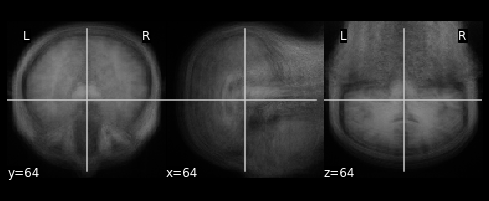

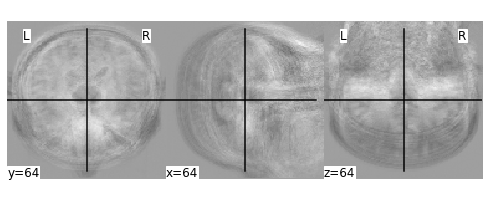

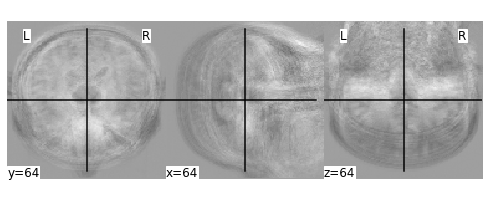

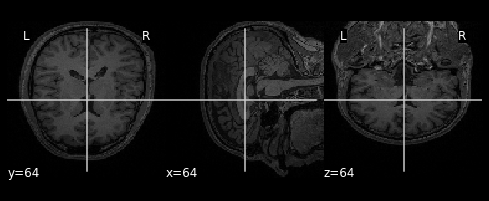

Max diff: 0.4000610473941402


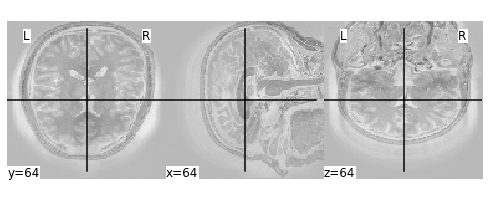

In [129]:
t1_means = np.array(pca128.mean_).reshape([1, -1]).reshape(t1_shape[1:])
t1_components1 = np.array(pca128.components_[0]).reshape([1, -1]).reshape(t1_shape[1:])
t1_components2 = np.array(pca128.components_[0]).reshape([1, -1]).reshape(t1_shape[1:])

img = nib.Nifti1Image(t1_means.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_a1nat(img, (64, 64, 64))
nlplt.show()

img = nib.Nifti1Image(t1_components1.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()

img = nib.Nifti1Image(t1_components2.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()

img = nib.Nifti1Image(t1_resize128_flatten[0].reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()

img2 = nib.Nifti1Image(t1_resize128_flatten[0].reshape([128, 128, 128]), np.eye(4))
diff = t1_means - t1_resize128_flatten[0]
img = nib.Nifti1Image(diff.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
print('Max diff:', np.max(diff))
nlplt.show()


128x128x128


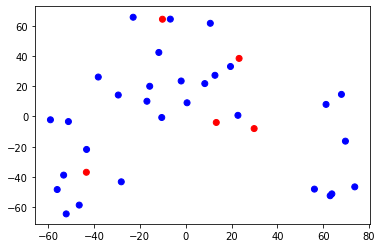

In [128]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
print('128x128x128')
pca128 = PCA(n_components=2)
pca128.fit(t1_resize128_flatten)
t1_transform = pca128.transform(t1_resize128_flatten[:30])
t1_transform_valid = pca128.transform(t1_resize128_flatten[30:])

colors = ['b' for x in range(len(t1_resize128_flatten[:30]))]
plt.scatter(t1_transform[:, 0], t1_transform[:, 1], c=colors)
colors = ['r' for x in range(len(t1_resize128_flatten[30:]))]
plt.scatter(t1_transform_valid[:, 0], t1_transform_valid[:, 1], c=colors)
plt.show()
plt.close()



In [ ]:
t1_means = np.array(pca.mean_).reshape([1, -1]).reshape(t1t2_shape[1:])
t1t2_components1 = np.array(pca.components_[0]).reshape([1, -1]).reshape(t1t2_shape[1:])
t1t2_components2 = np.array(pca.components_[1]).reshape([1, -1]).reshape(t1_shape[1:])

img = nib.Nifti1Image(t1t2_means.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()
img = nib.Nifti1Image(t1t2_components1.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()
img = nib.Nifti1Image(t1t2_components2.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()
img = nib.Nifti1Image(t1t2_resize128_flatten[0].reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()
img2 = nib.Nifti1Image(t1t2_resize128_flatten[0].reshape([128, 128, 128]), np.eye(4))
diff = t1t2_means - t1t2_resize128_flatten[0]
img = nib.Nifti1Image(diff.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
print('Max diff:', np.max(diff))
nlplt.show()


## Basic machine learning classification models

### Fisher's Linear Discriminant Analysis

Fisher's LDA is a classifier, but, like the PCA, it can also be used for dimentionality reduction. The PCA transforms the data to in a way that best explains the variance in the data. In contrast, Fisher's LDA transforms the data to in a way that best explains the variance between the classes.

In [106]:
def jitter(amp=0.01):
    return amp * (np.random.normal())

128x128x128


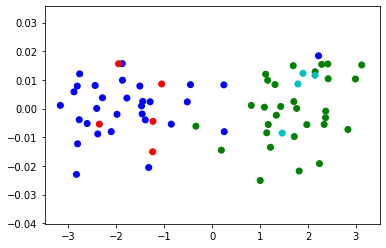

Accuracy:  0.9333333333333333


In [108]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
print('128x128x128')
lda128 = LDA()
labels = [0 for x in range(len(t1_resize128_flatten[:30]))] + [1 for x in range(len(t2_resize128_flatten[:30]))]
lda128.fit(t1t2_resize128_flatten, labels)
t1_transform = lda128.transform(t1_resize128_flatten[:30])
t2_transform = lda128.transform(t2_resize128_flatten[:30])
t1_transform_valid = lda128.transform(t1_resize128_flatten[30:])
t2_transform_valid = lda128.transform(t2_resize128_flatten[30:])

colors = ['b' for x in range(len(t1_resize128_flatten[:30]))]
plt.scatter(t1_transform[:, 0], [jitter() for _ in t1_transform[:, 0]], c=colors)
colors = ['g' for x in range(len(t2_resize128_flatten[:30]))]
plt.scatter(t2_transform[:, 0], [jitter() for _ in t2_transform[:, 0]], c=colors)
colors = ['r' for x in range(len(t1_resize128_flatten[30:]))]
plt.scatter(t1_transform_valid[:, 0], [jitter() for _ in t1_transform_valid[:, 0]], c=colors)
colors = ['c' for x in range(len(t2_resize128_flatten[30:]))]
plt.scatter(t2_transform_valid[:, 0], [jitter() for _ in t2_transform_valid[:, 0]], c=colors)
plt.show()
plt.close()

preds_t1 = lda128.predict(t1_resize128_flatten[:30])
labels_t1 = [0 for _ in preds_t1]
preds_t2 = lda128.predict(t2_resize128_flatten[:30])
labels_t2 = [1 for _ in preds_t2]
accuracy = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1, preds_t2)), np.concatenate((labels_t1, labels_t2)))]) / len(labels)
print('Accuracy: ', accuracy)



32x32x32


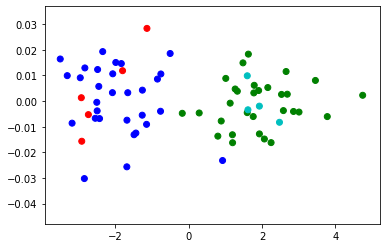

Train Accuracy:  0.9666666666666667
Valid Accuracy:  1.0


In [114]:
print('32x32x32')
lda32 = LDA()
labels = [0 for x in range(len(t1_resize32_flatten[:30]))] + [1 for x in range(len(t2_resize32_flatten[:30]))]
labels_valid = [0 for x in range(len(t1_resize32_flatten[30:]))] + [1 for x in range(len(t2_resize32_flatten[30:]))]
lda32.fit(t1t2_resize32_flatten, labels)
t1_transform = lda32.transform(t1_resize32_flatten[:30])
t2_transform = lda32.transform(t2_resize32_flatten[:30])
t1_transform_valid = lda32.transform(t1_resize32_flatten[30:])
t2_transform_valid = lda32.transform(t2_resize32_flatten[30:])

colors = ['b' for x in range(len(t1_resize32_flatten[:30]))]
plt.scatter(t1_transform[:, 0], [jitter() for _ in t1_transform[:, 0]], c=colors)
colors = ['g' for x in range(len(t2_resize32_flatten[:30]))]
plt.scatter(t2_transform[:, 0], [jitter() for _ in t2_transform[:, 0]], c=colors)
colors = ['r' for x in range(len(t1_resize32_flatten[30:]))]
plt.scatter(t1_transform_valid[:, 0], [jitter() for _ in t1_transform_valid[:, 0]], c=colors)
colors = ['c' for x in range(len(t2_resize32_flatten[30:]))]
plt.scatter(t2_transform_valid[:, 0], [jitter() for _ in t2_transform_valid[:, 0]], c=colors)
plt.show()
plt.close()

preds_t1 = lda32.predict(t1_resize32_flatten[:30])
labels_t1 = [0 for _ in preds_t1]
preds_t2 = lda32.predict(t2_resize32_flatten[:30])
labels_t2 = [1 for _ in preds_t2]
preds_t1_valid = lda32.predict(t1_resize32_flatten[30:])
labels_t1_valid = [0 for _ in preds_t1_valid]
preds_t2_valid = lda32.predict(t2_resize32_flatten[30:])
labels_t2_valid = [1 for _ in preds_t2_valid]
accuracy = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1, preds_t2)), np.concatenate((labels_t1, labels_t2)))]) / len(labels)
accuracy_valid = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1_valid, preds_t2_valid)), np.concatenate((labels_t1_valid, labels_t2_valid)))]) / len(labels_valid)
print('Train Accuracy: ', accuracy)
print('Valid Accuracy: ', accuracy_valid)



Visualization of LDA's attributes

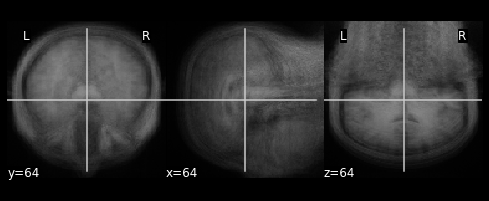

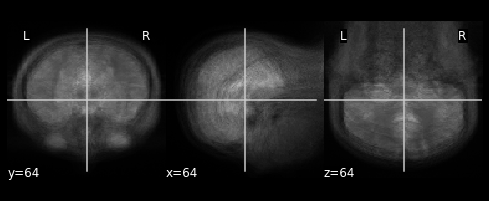

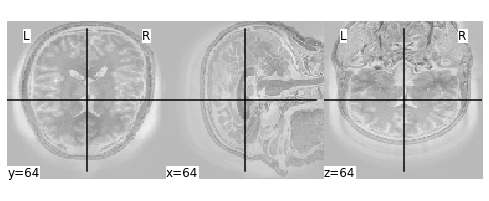

0.39732799596220886


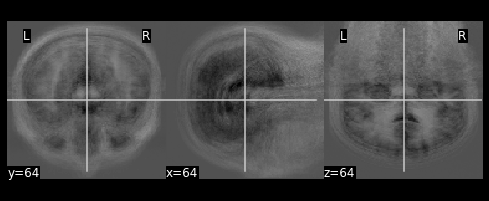

0.3570796855835298


In [118]:
t1_means_t1 = np.array(lda.means_[0]).reshape([1, -1]).reshape(t1_shape[1:])
t1_means_t2 = np.array(lda.means_[1]).reshape([1, -1]).reshape(t1_shape[1:])
img = nib.Nifti1Image(t1_means_t1.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()

img = nib.Nifti1Image(t1_means_t2.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()

diff = t1_means_t1 - t1_resize128_flatten[0]
img = nib.Nifti1Image(diff.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()
print(np.max(diff))

diff = t1_means_t1 - t1_means_t2
img = nib.Nifti1Image(diff.reshape([128, 128, 128]), np.eye(4))
nlplt.plot_anat(img, (64, 64, 64))
nlplt.show()
print(np.max(diff))


### Classification with a Support Vector Machine

A classification with a SVM, which is a non-linear classifier with a much higher capacity than the LDA or any other classifier that only support a linear decision boundary. This model performs particularily well for small datasets, though the high computational cost makes it inconvenient to use on large datasets of high dimentionality.

In [122]:
from sklearn.svm import SVC
print('128x128x128')
svc128 = SVC()
labels = [0 for x in range(len(t1_resize128_flatten[:30]))] + [1 for x in range(len(t2_resize128_flatten[:30]))]
labels_valid = [0 for x in range(len(t1_resize128_flatten[30:]))] + [1 for x in range(len(t2_resize128_flatten[30:]))]
svc128.fit(t1t2_resize128_flatten, labels)

preds_t1 = svc128.predict(t1_resize128_flatten[:30])
labels_t1 = [0 for _ in preds_t1]
preds_t2 = svc128.predict(t2_resize128_flatten[:30])
labels_t2 = [1 for _ in preds_t2]
preds_t1_valid = svc128.predict(t1_resize128_flatten[30:])
labels_t1_valid = [0 for _ in preds_t1_valid]
preds_t2_valid = svc128.predict(t2_resize128_flatten[30:])
labels_t2_valid = [1 for _ in preds_t2_valid]
accuracy = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1, preds_t2)), np.concatenate((labels_t1, labels_t2)))]) / len(labels)
accuracy_valid = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1_valid, preds_t2_valid)), np.concatenate((labels_t1_valid, labels_t2_valid)))]) / len(labels_valid)
print('Train Accuracy: ', accuracy)
print('Valid Accuracy: ', accuracy_valid)



128x128x128
Train Accuracy:  1.0
Valid Accuracy:  1.0


In [125]:
from sklearn.svm import SVC
print('32x32x32')
svc32 = SVC()
labels = [0 for x in range(len(t1_resize32_flatten[:30]))] + [1 for x in range(len(t2_resize32_flatten[:30]))]
labels_valid = [0 for x in range(len(t1_resize32_flatten[30:]))] + [1 for x in range(len(t2_resize32_flatten[30:]))]
svc32.fit(t1t2_resize32_flatten, labels)

preds_t1 = svc32.predict(t1_resize32_flatten[:30])
labels_t1 = [0 for _ in preds_t1]
preds_t2 = svc32.predict(t2_resize32_flatten[:30])
labels_t2 = [1 for _ in preds_t2]
preds_t1_valid = svc32.predict(t1_resize32_flatten[30:])
labels_t1_valid = [0 for _ in preds_t1_valid]
preds_t2_valid = svc32.predict(t2_resize32_flatten[30:])
labels_t2_valid = [1 for _ in preds_t2_valid]
accuracy = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1, preds_t2)), np.concatenate((labels_t1, labels_t2)))]) / len(labels)
accuracy_valid = sum([1 if pred == target else 0 for (pred, target) in zip(np.concatenate((preds_t1_valid, preds_t2_valid)), np.concatenate((labels_t1_valid, labels_t2_valid)))]) / len(labels_valid)
print('Train Accuracy: ', accuracy)
print('Valid Accuracy: ', accuracy_valid)



32x32x32
Train Accuracy:  1.0
Valid Accuracy:  1.0


Because it has a higher capacity, is has no problem classifying the data perfectly, even for the bigger images. 